# Credit Card Fraud Detection

The previous exercises made you take a closer look at all the different parts of a neural network: 
* the architecture of a sequential Dense Neural Network, 
* the compilation method
* the fitting.

Let's now work on a real-life dataset that has **a lot of data**!

**The dataset: `Credit Card Transactions`**

For this open challenge, you will `work with data extracted from credit card transactions`. 

As this is `sensitive data`, only 3 columns are known out of a total 31: the rest have been transformed to `anonymize` them (in fact, they are `PCA projections of initial data`).

The 3 known columns are:

* `TIME`: the time elapsed between the transaction and the first transaction in the dataset
* `AMOUNT`: the amount of the transaction
* `CLASS` (our target): 
    * `0 : valid transaction` 
    * `1 : fraudulent transaction`

❓ **Question** ❓ Start by downloading the dataset:
* on the Kaggle website [here](https://www.kaggle.com/mlg-ulb/creditcardfraud) 
* or from our [URL](https://wagon-public-datasets.s3.amazonaws.com/Machine%20Learning%20Datasets/creditcard.csv) 

Load data to create `X` and `y`

In [1]:
''' Linear Algebra'''
import pandas as pd
import numpy as np

''' Data visualization'''
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings

''' Scikit-Learn'''
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import confusion_matrix

''' Imbalanced Classes'''
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

''' Tensorflow Keras'''
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay



data = pd.read_csv('creditcard.csv')

y = data['Class']
X = data.drop('Class', axis=1)

2024-02-04 17:04:43.947514: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-04 17:04:44.054700: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-02-04 17:04:44.054724: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-02-04 17:04:44.072809: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-04 17:04:44.593615: W tensorflow/stream_executor/platform/de

## 1. Rebalancing classes

In [2]:
# Let's check class balance
pd.Series(y).value_counts(normalize=True)

0    0.998273
1    0.001727
Name: Class, dtype: float64

☝️ in this `fraud detection` challenge, **the classes are extremely imbalanced**:
* 99.8 % of normal transactions
* 0.2 % of fraudulent transactions

**We won't be able to detect cases of fraud unless we apply some serious rebalancing strategies!**

❓ **Question** ❓
1. **First**, create three separate splits `Train/Val/Test` from your dataset. It is extremely important to keep validation and testing sets **unbalanced** so that when you evaluate your model, it is done in true conditions, without data leakage. Keep your test set for the very last cell of this notebook!

&nbsp;
2. **Second**, rebalance your training set (and only this one). You have many choices:

- Simply oversample the minority class randomly using plain Numpy functions (not the best option since you are duplicating rows and hence creating data leakage)
- Or use <a href="https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/">**`Synthetic Minority Oversampling Technique - SMOTE`**</a> to generate new datapoints by weighting the existing ones
- In addition, you can also try a <a href="https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/">**`RandomUnderSampler`**</a> to downsample the majority class a little bit

In [3]:
# YOUR CODE HERE
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Train val split 
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.3)



In [4]:
# How many "fraud" samples do I have in each split?
print(np.sum(y_train[y_train == 1]))
print(np.sum(y_val[y_val == 1]))
print(np.sum(y_test[y_test == 1]))

print("-"*100)

print(f"There are {pd.Series(y_train).value_counts()[1]} fraudulent transactions in the train set")
print(f"There are {pd.Series(y_val).value_counts()[1]} fraudulent transactions in the val set")
print(f"There are {pd.Series(y_test).value_counts()[1]} fraudulent transactions in the test set")

235
110
147
----------------------------------------------------------------------------------------------------
There are 235 fraudulent transactions in the train set
There are 110 fraudulent transactions in the val set
There are 147 fraudulent transactions in the test set


In [5]:
# Sampling strategies

over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.33)

In [6]:
from sklearn import set_config;  set_config(display = 'diagram')  # show visual Pipeline

# Pipelining the two strategies
steps =  [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
pipeline

Pipeline(steps=[('o', SMOTE(sampling_strategy=0.1)),
                ('u', RandomUnderSampler(sampling_strategy=0.33))])

In [7]:
# Rebalance the dataset
X_train_resampled, y_train_resampled = pipeline.fit_resample(X_train, y_train)

print(f"X_train_resampled.shape = {X_train_resampled.shape}")
print(f"y_train_resampled.shape = {y_train_resampled.shape}")

X_train_resampled.shape = (56146, 30)
y_train_resampled.shape = (56146,)


In [8]:
# Reshuffle the resampled data just to be sure
stacked_resampled_data = np.hstack([X_train_resampled, y_train_resampled.values.reshape(-1,1)])
np.random.shuffle(stacked_resampled_data)

X_train_resampled = stacked_resampled_data[:,:30]
y_train_resampled = stacked_resampled_data[:,-1]
print(f"X_train_resampled.shape = {X_train_resampled.shape}")
print(f"y_train_resampled.shape = {y_train_resampled.shape}")

X_train_resampled.shape = (56146, 30)
y_train_resampled.shape = (56146,)


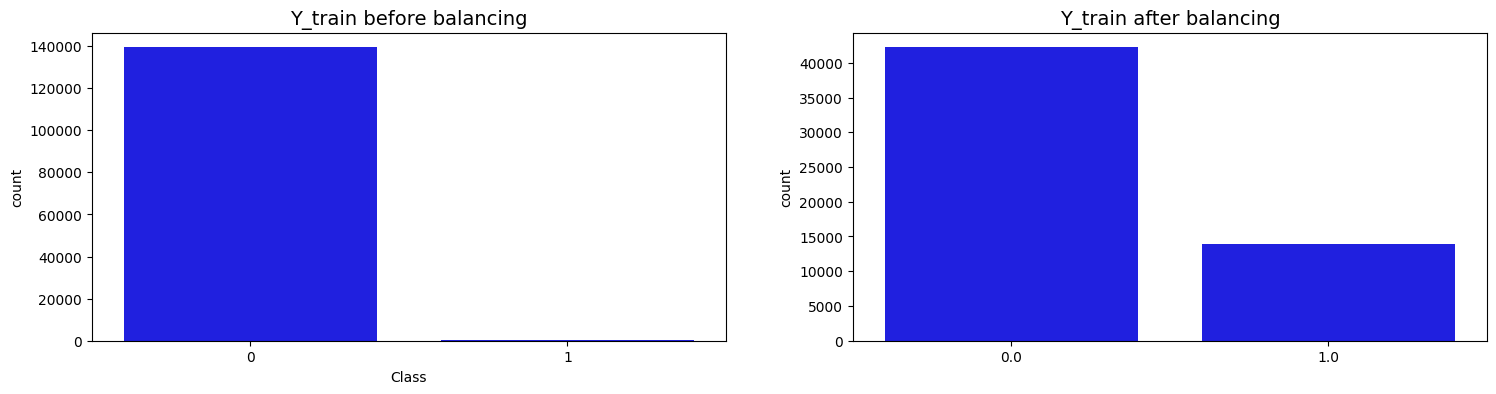

In [12]:
# plotting
warnings.filterwarnings('ignore')
fig, ax = plt.subplots(1, 2, figsize=(18,4))

''' Before rebalancing classes'''

sns.countplot(y_train, ax=ax[0], color='b')
ax[0].set_title('Y_train before balancing', fontsize=14)

''' After rebalancing classes'''

sns.countplot(y_train_resampled, ax=ax[1], color='b')
ax[1].set_title('Y_train after balancing', fontsize=14);

In [13]:
print(X_train_resampled.shape)
print(X_val.shape)

(56146, 30)
(59810, 30)


## 2. Neural Network iterations

Now that you have rebalanced your classes, try to fit a neural network to optimize your test score. Feel free to use the following hints:

- Normalize your inputs!
    - Use preferably a [`Normalization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Normalization) layer inside the model to "pipeline" your preprocessing within your model. 
    - Or use sklearn's [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) outside of your model, applied your `X_train` and `X_val` and `X_test`.
- Make your model overfit, then regularize  it using:
    - Early Stopping criteria 
    - [`Dropout`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) layers
    - or [`regularizers`](https://www.tensorflow.org/api_docs/python/tf/keras/regularizers) layers
- 🚨 Think carefully about the metrics you want to track and the loss function you want to use!


In [14]:
# YOUR CODE HERE
metrics = [
    keras.metrics.Recall(name='recall'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.AUC(name='prc', curve='PR'),  # precision-recall curve
]


2024-02-04 17:10:29.288899: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-04 17:10:29.289113: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-02-04 17:10:29.289179: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2024-02-04 17:10:29.289226: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2024-02-04 17:10:29.289268: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

In [45]:
from tensorflow.keras.layers import Normalization
from tensorflow.keras.metrics import Recall, Precision

def init_model():
    input_shape = X_train_resampled.shape[1:]
    normalizer = Normalization()
    normalizer.adapt(X_train_resampled)
    
    # Model Regularization, L1 may be needed incase dropout is not effective
    # reg_l1 = regularizers.L1(0.01)

    model = models.Sequential()
    model.add(normalizer)
    model.add(layers.Dense(30, activation='relu', input_dim = input_shape))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(6, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(1, activation = 'sigmoid'))

    # Model compilation
    optimizer = Adam(lr=0.0001)
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=metrics)
    return model

In [46]:
model = init_model()
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_3 (Normalizat  (None, 30)               61        
 ion)                                                            
                                                                 
 dense_12 (Dense)            (None, 30)                930       
                                                                 
 dropout_9 (Dropout)         (None, 30)                0         
                                                                 
 dense_13 (Dense)            (None, 16)                496       
                                                                 
 dropout_10 (Dropout)        (None, 16)                0         
                                                                 
 dense_14 (Dense)            (None, 6)                 102       
                                                      

In [47]:

es = EarlyStopping(
    patience=10,
    monitor='val_recall', # Recall is a metric that measures the ability of a model to capture all positive instances (fraudulent transactions) among the actual positive instances.
    restore_best_weights=True)

history = model.fit(X_train_resampled, y_train_resampled,
                    validation_data=(X_val, y_val),
                    epochs=100,
                    batch_size=64, # By using a larger batch size (in this case, 64), there is a higher chance that each batch will contain at least a few fraudulent transactions
                    callbacks=[es], shuffle=True)

Epoch 1/100
878/878 [==============================] - 3s 2ms/step - loss: 0.6015 - recall: 0.6212 - precision: 0.4989 - prc: 0.6843 - val_loss: 0.4346 - val_recall: 0.7909 - val_precision: 0.4416 - val_prc: 0.6755
Epoch 2/100
878/878 [==============================] - 2s 2ms/step - loss: 0.3183 - recall: 0.6638 - precision: 0.9438 - prc: 0.8706 - val_loss: 0.0703 - val_recall: 0.8091 - val_precision: 0.8165 - val_prc: 0.7256
Epoch 3/100
878/878 [==============================] - 2s 2ms/step - loss: 0.2089 - recall: 0.7584 - precision: 0.9752 - prc: 0.9217 - val_loss: 0.0300 - val_recall: 0.8273 - val_precision: 0.7521 - val_prc: 0.7575
Epoch 4/100
878/878 [==============================] - 2s 2ms/step - loss: 0.1794 - recall: 0.7972 - precision: 0.9770 - prc: 0.9411 - val_loss: 0.0227 - val_recall: 0.8455 - val_precision: 0.6503 - val_prc: 0.7586
Epoch 5/100
878/878 [==============================] - 2s 2ms/step - loss: 0.1639 - recall: 0.8432 - precision: 0.9780 - prc: 0.9538 - val_l

In [48]:
def plot_loss_precision_recall_curve(history):
    
    fig, ax =plt.subplots(1,3,figsize=(20,5))
    
    # --- LOSS
    
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend(['Train', 'Val'], loc='upper right')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
    # --- RECALL

    ax[1].plot(history.history['recall'])
    ax[1].plot(history.history['val_recall'])
    ax[1].set_title('Model recall', fontsize = 18)
    ax[1].set_xlabel('Epoch', fontsize = 14)
    ax[1].set_ylabel('Recall', fontsize = 14)
    ax[1].legend(['Train', 'Val'], loc='lower right') 
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)

    
    # --- PRECISION
    
    
    ax[2].plot(history.history['precision'])
    ax[2].plot(history.history['val_precision'])
    ax[2].set_title('Model precision', fontsize = 18)
    ax[2].set_xlabel('Epoch', fontsize = 14)
    ax[2].set_ylabel('Precision', fontsize = 14)
    ax[2].legend(['Train', 'Val'], loc='lower right')  
    ax[2].grid(axis="x",linewidth=0.5)
    ax[2].grid(axis="y",linewidth=0.5)    
    
    plt.show()

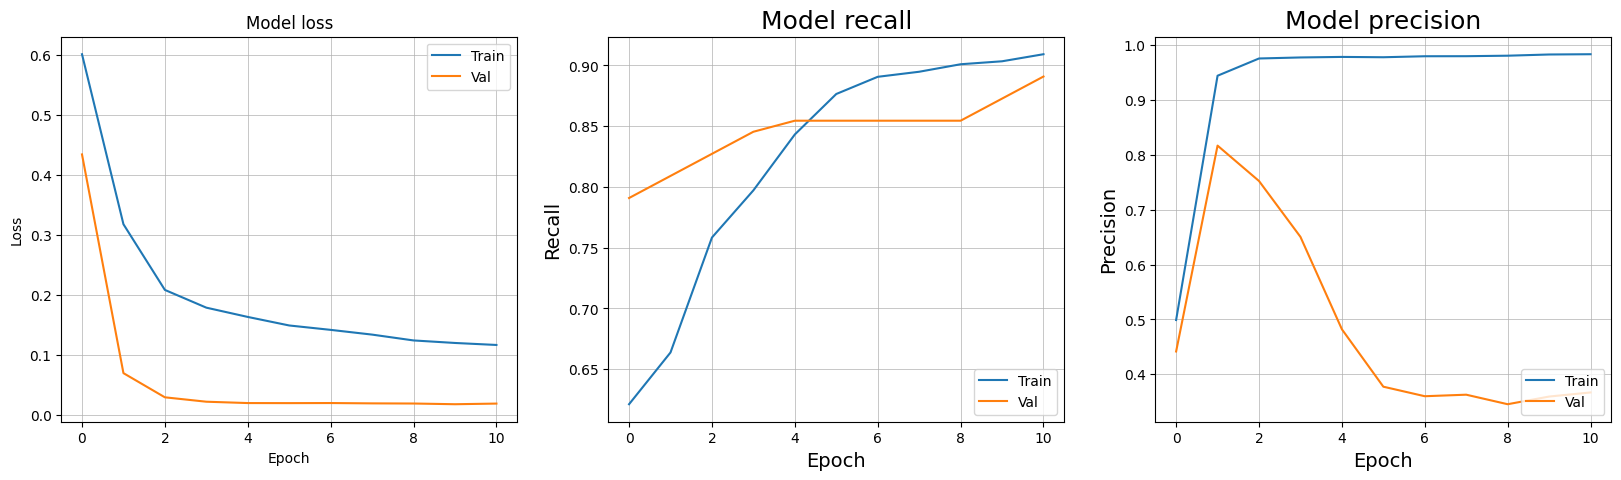

In [49]:
plot_loss_precision_recall_curve(history)

### 🧪 Test your score

Store below your real test performance on a (`X_test`, `y_test`) representative sample of the original unbalanced dataset into `precision` and `recall` variables.

In [50]:
# YOUR CODE HERE

ev = model.evaluate(X_test, y_test, verbose=0, return_dict=True)
precision = ev['precision']
recall = ev['recall']

In [51]:
from nbresult import ChallengeResult

result = ChallengeResult('solution',
    precision=precision,
    recall=recall,
    fraud_number=len(y_test[y_test == 1]),
    non_fraud_number=len(y_test[y_test == 0]),
)

result.write()
print(result.check())


============================= test session starts ==============================
platform linux -- Python 3.10.6, pytest-7.1.3, pluggy-1.0.0 -- /home/amin/.pyenv/versions/lewagon/bin/python3
cachedir: .pytest_cache
rootdir: /home/amin/code/A-Diafi/06-Deep-Learning/02-Optimizer-loss-and-fitting/data-credit-card-challenge/tests
plugins: anyio-3.6.2, typeguard-2.13.3, asyncio-0.19.0
asyncio: mode=strict
collecting ... collected 2 items

test_solution.py::TestSolution::test_is_score_good_enough PASSED         [ 50%]
test_solution.py::TestSolution::test_is_test_set_representative PASSED   [100%]

============================== 2 passed in 0.01s ===============================


💯 You can commit your code:

git add tests/solution.pickle

git commit -m 'Completed solution step'

git push origin master



## 🏁 Optional: Read Google's solution for this challenge
Congratulations for finishing all challenges for this session!

To conclude, take some time to read Google's own solution direcly [on Colab here](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/structured_data/imbalanced_data.ipynb). 

You will discover interesting techniques and best practices